# Molecular VAE

In [1]:
# packages
import pandas as pd
import numpy as np
import tqdm
import torch
import torch.utils.data as tud
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split

# project modules
from utils import SMILESTokenizer, SMILESVocabulary, SMILESDataset, countTokens
from models import MolecularVAE

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# chemistry
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True  #set this to False if you want PNGs instead of SVGs

RDKit WARNING: [18:37:51] Enabling RDKit 2019.09.1 jupyter extensions


## Load data

In [2]:
chembl = pd.read_csv("data/cleaned_dataset.csv")
chembl.head()

,ChEMBL ID,Smiles,AlogP,QED Weighted
0,CHEMBL2333117,CC(C)Nc1c(C(N)=O)nnc2ccc(-c3cnn(C)c3)cc12,1.95,0.77
1,CHEMBL1189585,CC1C(=O)NC2=Nc3sc4c(c3CN21)CCCC4,1.95,0.78
2,CHEMBL4089494,CNC(=O)c1ccc(NC(=O)Nc2ccc(-c3nc(N4CCOCC4)c4ncc...,3.53,0.40
3,CHEMBL1189590,CN(C)c1nccc2c1nnn2Cc1ccccc1F,2.08,0.73
4,CHEMBL3927722,Cc1noc(C)c1Cn1cc(NC(=O)Cc2ccco2)cn1,2.31,0.78


## Data preparation & encoding

Steps to prepare VAE input data:
1. SMILES tokenization (add start/end tokens)
2. SMILES token encoding (convert to integer indecies) -> build a vocabulary
3. Set up a SMILES dataset class (for feeding batches of data to the VAE)

### Build a vocabulary

In [3]:
tokenizer = SMILESTokenizer()
vocabulary = SMILESVocabulary()

In [4]:
# vocabulary.build(chembl["Smiles"], tokenizer)

In [5]:
# # save vocabulary
# vocabulary.save("data/vocabulary.csv")

In [4]:
# load vocabulary
vocabulary.load("data/vocabulary.csv")

### Analyze token frequencies

In [11]:
token_cnts = countTokens(chembl["Smiles"], tokenizer)
token_cnts

,token,cnt
0,C,12896279
1,(,7025189
2,),7025189
3,N,2682981
4,c,18431345
5,1,4604265
6,=,2904352
7,O,4388805
8,n,2124346
9,2,3590237


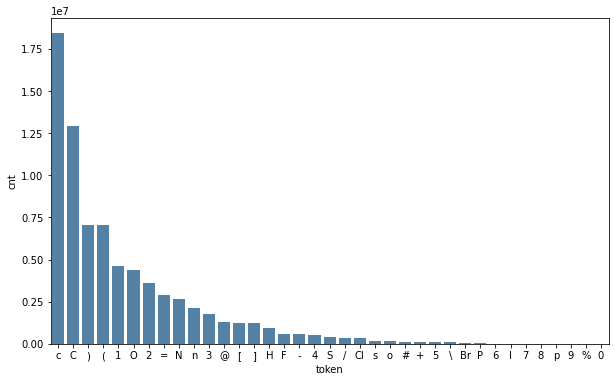

In [12]:
# plot token distribution
fig, ax = plt.subplots(figsize=(10, 6))
_ = sns.barplot(data=token_cnts.sort_values("cnt", ascending=False), x="token", y="cnt", color="steelblue", ax=ax)

## Train/validation/test split

A randomly selected validation and test set will be put aside for monitoring the network training process itself (validation set) and evaluating the trained models (test set).

Models will be evaluated in terms of the mean **E**vidence **L**ower **BO**und (**ELBO**) of the test set sequences (SMILES). The higher the better. This is equivalent to to saying that the loss function (which is the negative ELBO) should be as low as possible: 

$$L(S;\theta)=-ELBO(S;\theta)=KL(S;\theta) + NLL(S;\theta)$$

where S is the set of SMILES strings in the test set, $KL(S;\theta)$ is the mean KL divergence of the test set (obtained from the encoder of the VAE), and $NLL(S;\theta)$ is the mean neg. log-likelihood of the test set (obtained from the decoder of the VAE). See bellow.

In [5]:
train, test = train_test_split(chembl, test_size=0.1, random_state=42)
train, validation = train_test_split(train, test_size=0.1, random_state=42)

In [6]:
train.shape

(1292494, 4)

### Build a dataset

A dataset is created for each split so batches of samples can easily be fed to the model.

In [7]:
train_ds = SMILESDataset(train["Smiles"], vocabulary, tokenizer)
val_ds = SMILESDataset(validation["Smiles"], vocabulary, tokenizer)
test_ds = SMILESDataset(test["Smiles"], vocabulary, tokenizer)

## VAE models

The variational autoencoder consists of the following components:
1. SMILES encoder: maps input sequences to a latent vector z.
2. Decoder: decodes a latent vector z into a sequence.

In [8]:
vae = MolecularVAE(len(vocabulary), 8, 64, 128, vocabulary.getStartIdx(), vocabulary.getEndIdx(), 
                   vocabulary.getPadIdx(), rnn_layers=2, bidirectional=True, dropout=0.1)

## Model training

### The loss function

The loss function used for training the VAE is the negative of the **E**vidence **L**ower **BO**und (**ELBO**). ELBO consists of 2 terms, and represents the lower bound on the marginal log-likelihood of the data:

$$ELBO(S;\theta) = E_{q_{\theta}(Z|S)}[\log{p_{\theta}(S|Z)}] - KL(q_{\theta}(Z|S) \lVert p(Z)) \leq \log{p(S)}$$

Here, $Z$ is the latent variable, $S$ is the observed SMILES data (evidence), $q_{\theta}(Z|S)$ (encoder output) is the approximation to the true posterior distribution - $p(Z|S)$, $p_{\theta}(S|Z)$ is the conditional distribution over $S$ given $Z$ (decoder output), $p(Z)$ is the prior ditribution of the latent variable $Z$, and $p(S)$ is the marginal distribution of the data.

The first term is estimated using a single sample drawn from the approximate posterior, whereas the KL term is computed analytically in closed form. The goal of the optimization is to maximize the lower bound, and this can be achieved by minimizing its negative (the loss function):

$$L(S;\theta) = -\log{p_{\theta}(S|Z)} + KL(q_{\theta}(Z|S) \lVert p(Z))$$

Here also the expectation term was replaced by the neg. log-likelihood of $S$ given a single $Z$ drawn from $q_{\theta}(Z|S)$ as explained above. For a minibatch of samples - $S$, the loss function then becomes:

$$L(S;\theta) = -\frac{1}{m}\sum_{i=1}^{m} \log{p_{\theta}(S_i|Z_i)} + \frac{1}{m}\sum_{i=1}^{m} KL(q_{\theta}(Z_i|S_i) \lVert p(Z))=NLL + KL$$

Here, $i$ is a particular example from a batch of $m$ samples.

Because $q_{\theta}(Z_i|S_i)$ and $p(Z)$ are both chosen to be diagonal multivariate gaussians and in particular $p(Z) \sim \mathcal{N}(0, I)$, the KL divergence term can be computed analytically in closed form:

$$KL(q_{\theta}(Z_i|S_i) \lVert p(Z)) = \frac{1}{2}\left(\lVert\mu_q\lVert^2 - k + tr\{\Sigma_q\} - \log{|\Sigma_q|}\right)=\frac{1}{2}\left(\sum_{j=1}^{k} \mu_j^2 - k + \sum_{j=1}^{k} \nu_j - \sum_{j=1}^{k} \log{\nu_j}\right)=\frac{1}{2}\sum_{j=1}^{k}\left(\mu_j^2 - 1 + \nu_j - \log{\nu_j}\right)$$

where $\mu_j$ and $\nu_j$ are the $j^{th}$ components of the mean and variance vectors of $q_{\theta}(Z_i|S_i)$

In [9]:
def compute_loss(model:nn.Module, batch:torch.Tensor) -> tuple:
    """Computes the NLL and KL loss for a batch of sequences"""
    batch_sz = batch.size(0)
    # prepare targets (input shifted 1 step to the left and padded with pad idx)
    targets = batch.roll(shifts=-1, dims=1)
    targets[:, -1] = model.pad_idx
    # prepare predictions
    logp, _, mean, logv = model(batch)
    preds = logp.permute(0, 2, 1)
    # compute NLL (neg. log likelihood) loss for the target sequence (ignore padding idx)
    nll_loss = F.nll_loss(preds, targets, ignore_index=model.pad_idx, reduction="sum") / batch_sz
    # compute KL loss
    kl_loss = -0.5 * torch.sum(1 + logv - mean.pow(2) - logv.exp()) / batch_sz
    # compute total loss (averged within a batch)
    return (nll_loss, kl_loss)

def annealing_func(nll_loss:torch.Tensor, kl_loss:torch.Tensor, s:int, m:int, w:int) -> torch.Tensor:
    """
    Controls the final loss function through an adjustable KL weight
    -------------------
    s - iteration step
    m - midpoint (iteration step at which the KL weight is 0.5)
    w - width (smoothnes of the sigmoid annealing function around the midpoint)
    """
    kl_weight = 1 / (1 + np.exp(-(s - m)/w))
    return nll_loss + kl_weight * kl_loss


### Create an optimizer

In [10]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

### Train the model

In [29]:
NUM_EPOCHS = 1
BATCH_SZ = 128
KLW_MIDPOINT = 4000
KLW_WIDTH = 1000

In [30]:
step = 0
for e in range(1, NUM_EPOCHS+1):
    print("Epoch: %i" %e)
    # train model on the training set
    dataloader = tud.DataLoader(train_ds, batch_size=BATCH_SZ, shuffle=True, collate_fn=train_ds.getCollateFn())
    # enable dropout
    vae.train()
#     train_scores = {"ELBO":[], "NLL":[], "KL":[]}
    for b, batch in enumerate(dataloader):
        optimizer.zero_grad()
        # compute loss
        nll_loss, kl_loss = compute_loss(vae, batch)
        loss = annealing_func(nll_loss, kl_loss, step, KLW_MIDPOINT, KLW_WIDTH)
        # compute gradients
        loss.backward()
        # update weights
        optimizer.step()
        step += 1
        # print training progress
        if b % 100 == 0:
            print("Training batch: %i, ELBO: %.4f, NLL: %.4f, KL div: %.4f" % (b, 
                                   loss.item(), nll_loss.item(), kl_loss.item()))
    # evaluate on the validation set
    dataloader = tud.DataLoader(val_ds, batch_size=BATCH_SZ, shuffle=False, collate_fn=val_ds.getCollateFn())
    # disable dropout
    vae.eval()
    val_scores = {"ELBO":[], "NLL":[], "KL":[]}
    for b, batch in enumerate(dataloader):
        nll_loss, kl_loss = compute_loss(vae, batch)
        loss = nll_loss + kl_loss
        val_scores["ELBO"].append(loss.item())
        val_scores["NLL"].append(nll_loss.item())
        val_scores["KL"].append(kl_loss.item())
    val_mean = {k:np.mean(v) for k, v in val_scores.items()}
    print("Epoch %i validation scores: ELBO: %.4f, NLL: %.4f, KL div: %.4f" % (e, 
                                   val_mean["ELBO"], val_mean["NLL"], val_mean["KL"]))



Epoch: 1
Training batch: 0, ELBO: 179.66, NLL: 179.65, KL div: 0.52
Training batch: 100, ELBO: 39.01, NLL: 38.76, KL div: 12.90
Training batch: 200, ELBO: 5.01, NLL: 4.89, KL div: 5.70
Training batch: 300, ELBO: 1.48, NLL: 1.39, KL div: 3.52
Training batch: 400, ELBO: 0.84, NLL: 0.78, KL div: 2.08
Training batch: 500, ELBO: 0.38, NLL: 0.34, KL div: 1.42
Training batch: 600, ELBO: 0.27, NLL: 0.24, KL div: 0.92
Training batch: 700, ELBO: 0.45, NLL: 0.43, KL div: 0.63
Training batch: 800, ELBO: 0.21, NLL: 0.19, KL div: 0.41
Training batch: 900, ELBO: 0.13, NLL: 0.12, KL div: 0.21
Training batch: 1000, ELBO: 0.15, NLL: 0.15, KL div: 0.10
Training batch: 1100, ELBO: 0.08, NLL: 0.08, KL div: 0.05
Training batch: 1200, ELBO: 0.09, NLL: 0.09, KL div: 0.03
Training batch: 1300, ELBO: 0.08, NLL: 0.08, KL div: 0.01
Training batch: 1400, ELBO: 0.04, NLL: 0.04, KL div: 0.01
Training batch: 1500, ELBO: 0.17, NLL: 0.17, KL div: 0.00
Training batch: 1600, ELBO: 0.03, NLL: 0.03, KL div: 0.00
Training b

ValueError: too many values to unpack (expected 2)

In [32]:
val_mean = {k:np.mean(v) for k, v in val_scores.items()}
print("Epoch %i validation scores: ELBO: %.4f, NLL: %.4f, KL div: %.4f" % (e, 
                               val_mean["ELBO"], val_mean["NLL"], val_mean["KL"]))

Epoch 1 validation scores: ELBO: 0.0004, NLL: 0.0004, KL div: 0.0000


### Persist trained model

In [34]:
# torch.save(vae.state_dict(), "saved_models/gru_vae.pt")

### Load trained model

In [11]:
vae.load_state_dict(torch.load("saved_models/gru_vae.pt"))
# set to inference mode
vae.eval()

MolecularVAE(
  (embedding): Embedding(40, 8, padding_idx=0)
  (encoder_rnn): GRU(8, 64, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (hidden2mean): Linear(in_features=256, out_features=128, bias=True)
  (hidden2logv): Linear(in_features=256, out_features=128, bias=True)
  (latent2hidden): Linear(in_features=128, out_features=256, bias=True)
  (decoder_rnn): GRU(8, 64, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (outputs2vocab): Linear(in_features=128, out_features=40, bias=True)
)

## Generate sequences

In [18]:
samples = vae.generateSequences(n=32, max_len=150, greedy=False)

In [19]:
gen_mols = [tokenizer.untokenize(vocabulary.decode(s)) for s in samples.tolist()]
gen_mols

['C(C',
 '',
 'Cl))CC7P)C11n(CClnn==BrBrcBrBrN=====BrBr==PBr)====)==P=P============PBr==P===PBrBrBr5==PBr==Br=P==PBrBrBrBrBr=Br=P=Br5=PBr5Br=======Br=PBr==PPPBrBrBr)==========Br=P====BrBr)Br5)BrBr5PP',
 'CBrBr))C',
 'SNNBr5)CBr)CO',
 '5O]==Br)SN)c1)SC]',
 '==N(N=BrCScc1Br)[O',
 '8))==C==CBr=)N=c1CCNN=PBr5',
 '==N)Br=C)NCCcCC=)cN=N8]]CN))C]N8]NNC]CNNNNO]NCC8@]NON3N8]3N3NO]NCCONNO]]N3]]NCC]N3N8]]NCCNNCONNNCI]NO3]NO]]OINNCCCNN]NCI]OC]3(CC]]NNC(NCNCINNNc/',
 ')Br)[N)=[)NN===Nccccc=====P=N==N=N=N==N==N==N==N===N=N====N=N=N=N]==N==N==N==N===N=====N======N]=N=N=N===N======N====N=N=N=N===N==N=N=N==N=N',
 '=O1Br5N)BrN))N)Br=PP]SN)))))S)Br)Br[Br)Br)S)S))Br))Br)Br))))Br))))BrBr))Br))[)BrBr)Br)Br)Br))Br)))cBrBr))Br)BrBr)=))S)Br)Br[)Br)S)Br)S)Br))SBr)Br5))cc5)Br))[)Br)Br)Br)Br)Br)Br)[Br)Br)=BrS5)BrBr',
 'Br)N',
 'OCCNsBrNs)NN=#',
 'N3nC\\s)\\sBrBr)BrBr)CCBr==SNNNN[c5=Br=P=Br==Br=PPPBr[N[BrClCl=PPBr=P=N=P)=N==N=NN=[NPNNNN3S=P=)N1P[SBr===Br=BrP==[N[N=N[Br[=SS=BrSN=ClPBr5PBrNBr=PPN/=N[BrClPP===N=[Br5B

In [22]:
# try sampling from a posterior of a sample from the test set
tokenizer.untokenize(vocabulary.decode(test_ds[0].tolist()))

'O=C(/C=C/c1ccc2c(c1)C(=O)N(Cc1ccccc1)C1(CCNCC1)O2)NO'

In [25]:
logp, z, mean, logv = vae(test_ds[0].reshape(1, -1))

In [31]:
samples2 = vae.generateSequences(z=z, max_len=150, greedy=False)
samples2

RuntimeError: bool value of Tensor with more than one value is ambiguous

In [43]:
rand = torch.rand(1).repeat(40)
rand.shape

torch.Size([40])

In [44]:
rand

tensor([0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751,
        0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751,
        0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751,
        0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751, 0.3751,
        0.3751, 0.3751, 0.3751, 0.3751])

In [45]:
cumsum = logp.exp()[0,0,:].cumsum(-1)
cumsum

tensor([3.5430e-10, 9.6822e-10, 4.6560e-08, 4.6630e-08, 4.7742e-08, 1.1781e-07,
        1.7558e-07, 2.3136e-07, 2.3652e-07, 2.3656e-07, 2.3768e-07, 2.8132e-07,
        3.2993e-07, 3.2996e-07, 3.3000e-07, 3.3321e-07, 3.3329e-07, 4.4612e-07,
        8.4286e-07, 8.4300e-07, 1.2537e-06, 1.3216e-06, 1.3216e-06, 1.3627e-06,
        1.3824e-06, 1.3862e-06, 1.5509e-06, 1.6564e-06, 1.6565e-06, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00],
       grad_fn=<CumsumBackward>)

In [48]:
(rand > cumsum).long().sum(-1)

tensor(29)